In [2]:
'''
Import libraries
'''
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit.visualization import plot_histogram

from qiskit.providers.fake_provider import FakeAuckland
from qiskit.providers.fake_provider import FakeGuadalupeV2

from qiskit import *

from qiskit.utils import QuantumInstance
from qiskit.providers.ibmq import least_busy

from qiskit.circuit.random import random_circuit

from qiskit.primitives import Sampler as prim_Sampler
from qiskit_ibm_runtime import Sampler as run_Sampler
from qiskit_ibm_runtime import Session, Options
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import RZGate

import warnings
warnings.filterwarnings("ignore")

from qiskit.circuit import Qubit, QuantumRegister, CircuitInstruction, Instruction

from qiskit.providers.aer.noise import NoiseModel

In [3]:
'''
Qiskit Service backends
'''
#Use this for old account.
#service = QiskitRuntimeService()

#Use this for NSF account.
#service = QiskitRuntimeService(name="SR-NSF")
#service.backends()

'\nQiskit Service backends\n'

In [4]:
def createEqSuperpos(numElements):
    '''
    Returns Quantum Circuit that creates an equal superposition on numElements.
    '''
    if (math.log2(numElements).is_integer()):
        k = int(np.log2(numElements))
        temp = QuantumCircuit(k)
        for i in range(k):
            temp.h(i)
    else:
        k = int(np.ceil(np.log2(numElements)))
        temp = QuantumCircuit(k)
        frac = np.sqrt(numElements - 2**(k-1))/((np.sqrt(2))**(k-1))
        theta = 2*np.arctan(frac)
        temp.ry(theta, [0])
        temp.x(0)
        for i in range(1, k):
            temp.ch(0, i)
        temp.x(0)
        left = numElements - 2**(k-1)
        if (left == 1):
            return temp
        else:
            leftk = k - int(np.ceil(np.log2(left)))
            recCall = createEqSuperpos(left).to_gate()
            appCir = recCall.control(num_ctrl_qubits=leftk)
            for i in range(1, leftk):
                temp.x(i)
            temp.append(appCir, range(k))
            for i in range(1, leftk):
                temp.x(i)
    return temp

In [14]:
def createW(n):
    '''
    Creates n-qubit W state.
    '''
    temp = QuantumCircuit(n)
    temp.ry(2*np.arccos(1/np.sqrt(n)), 0)
    for i in range(n-2):
        temp.ch(i, i+1)
    for i in range(n-1):
        temp.cx(n-i-2, n-i-1)
    temp.x(0)
    return temp

In [13]:
def get_dist(state):
    '''
    Get true distribution of Hamming weight outcomes for the input state.
    '''
    backend = Aer.get_backend('statevector_simulator')
    result = execute(state, backend).result().get_statevector()
    dic = {}
    for i in range(len(np.asarray(result))):
        if np.abs(result[i])>=1e-6:
            st = bin(i)
            count = 0
            for k in range(len(st)):
                if (st[k] == '1'):
                    count += 1
            if (count in dic):
                dic[count] += np.real((result[i])*np.conj(result[i]))
            else:
                dic[count] = np.real((result[i])*np.conj(result[i]))

    return dic

In [5]:
def createQuantumCircuit(state):
    '''
    Creates quantum circuit for the problem. 
    '''
    n = state.num_qubits
    k = int(np.ceil(np.log2(n+1)))
    w = 2**k - (n+1)
    N = n + w
    
    circ = QuantumCircuit(k + n, k)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperpos(2**k)
    circ.append(superPosCircuit.reverse_bits(), list(range(0, k)))
    
    circ.append(state, list(range(k, k + n)))
    
    for i in range(k):
        y = 2**i
        circ.append(RZGate(np.pi*(N-w)*y/(N+1)), [i])
    circ.barrier()
    
    for i in range(k):
        t = k-i-1
        y = 2**t
        for j in range(n):
            tqubit = k+j
            circ.append(RZGate(2*np.pi*y/(N+1)).control(1), [t, tqubit])
        circ.barrier()
    
    circ.append(QFT(k).inverse(), list(range(0, k)))
    circ.measure(list(range(0, k)), list(range(0, k)))
    return circ

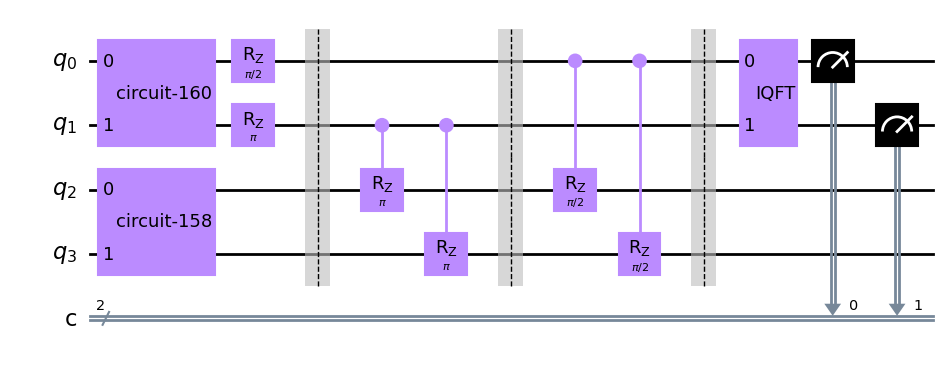

In [6]:
state = QuantumCircuit(2)
createQuantumCircuit(state).draw('mpl')

In [7]:
def measOutcomes(qCirc, shots, choice = 0):
    '''
    Calculates the expectation value for the different backends.
    '''
    if choice == 0: 
        #Noiseless Simulation
        sampler = prim_Sampler()
        job = sampler.run(qCirc)
        
    elif choice == 1:
        sampler = prim_Sampler()
        job = sampler.run(qCirc, shots = shots)
        
    elif choice == 2:
        fake_backend = FakeGuadalupeV2()
        noise_model = NoiseModel.from_backend(fake_backend)
        options = Options()
        options.simulator = {
            "noise_model": noise_model,
            "coupling_map": fake_backend.coupling_map,
            "seed_simulator": 42
        }
        options.optimization_level = 3
        options.resilience_level = 1
        
        sampler = run_Sampler(session=session1, options=options)
        job = sampler.run(qCirc, shots=shots)
        
    elif choice == 3:
        options = Options(optimization_level=3, resilience_level=1)
        sampler = run_Sampler(session=session2, options=options)
        job = sampler.run(qCirc, shots=shots)

    return job

In [8]:
LB = least_busy(service.backends(filters=lambda x: x.configuration().n_qubits >= 20 and not x.configuration().simulator))
print(LB)

session1 = Session(service=service, backend="ibmq_qasm_simulator")
session2 = Session(service=service, backend=LB.name)

<IBMBackend('ibm_osaka')>


In [10]:
def writeToFile(filename, qt_back_name, qasm, lis_exp):
    '''
    Write the data to a text file to be used to plot the data. The format is as follows:
        1. QASM description of state preparation unitary
        2. true_dist
        3. dic_noiseless
        4. dic_shot_noise
        5. dic_noisy_sim
        6. dic_quantum
    '''
    file = open(filename, "w+")
    file.write(qasm)
    for i in range(len(lis_exp)):
        file.write(str(lis_exp[i]) + "\n")
    file.write(qt_back_name+"\n")
    file.close()

In [11]:
def populate_dicts(data_experiments):
    '''
    Extracts output data from IBM cloud jobs.
    '''
    for i in range(len(data_experiments)):
        if (str(type(data_experiments[i][3])) == "<class 'qiskit_ibm_runtime.runtime_job.RuntimeJob'>"):
            if str(data_experiments[i][3].status()) == "JobStatus.DONE":
                data_experiments[i][3] = data_experiments[i][3].result().quasi_dists[0]
        
        if (str(type(data_experiments[i][4])) == "<class 'qiskit_ibm_runtime.runtime_job.RuntimeJob'>"):
            if str(data_experiments[i][4].status()) == "JobStatus.DONE":
                data_experiments[i][4] = data_experiments[i][4].result().quasi_dists[0]
            
    return data_experiments

In [7]:
def get_data_experiments(list_experiments, shots):
    '''
    Runs all experiments and returns data array.
    '''
    data_experiments = []
    for i in list_experiments:
        data_experiments.append([])
    
    for i in range(len(list_experiments)):
        state = list_experiments[i]
        
        true_dist = get_dist(state)
        dic_noiseless = measOutcomes(createQuantumCircuit(state), shots, 0).result().quasi_dists[0]
        dic_shot_noise = measOutcomes(createQuantumCircuit(state), shots, 1).result().quasi_dists[0]
        dic_noisy_sim = measOutcomes(createQuantumCircuit(state), shots, 2)
        dic_quantum = measOutcomes(createQuantumCircuit(state), shots, 3)
        
        #dic_noisy_sim and dic_quantum hold a JOB now. Not the distribution.
        data_experiments[i] = [true_dist, dic_noiseless, dic_shot_noise, dic_noisy_sim, dic_quantum]
    
    return data_experiments

In [43]:
"Define a list of quantum states to test Hamming weight. Need to do it this way to reduce queueing time."
list_experiments = []
list_names = ["8-qubit-GHZ", "8-qubit-W", "8-qubit-W-W"]

#1
state = QuantumCircuit(8)
state.h(0)
state.cx(0, 1)
state.cx(1, 2)
state.cx(2, 3)
state.cx(3, 4)
state.cx(4, 5)
state.cx(5, 6)
state.cx(6, 7)
list_experiments.append(state)

#2
state = createW(8)
list_experiments.append(state)

#3
state = QuantumCircuit(8)
state.append(createW(4), [0, 1, 2, 3])
state.append(createW(4), [4, 5, 6, 7])
list_experiments.append(state)

In [44]:
data_experiments = get_data_experiments(list_experiments, 10000)

In [46]:
data_experiments = populate_dicts(data_experiments)
print(data_experiments)

[[{0: 0.5000000000000001, 8: 0.4999999999999999}, {0: 0.4999999999999991, 8: 0.4999999999999989}, {0: 0.507, 8: 0.493}, {0: 0.23165707907462657, 1: 0.04131894706513416, 2: 0.05401777764172935, 3: 0.02648862642635223, 4: 0.08155648872051376, 5: 0.02914307117041534, 6: 0.056423435942688456, 7: 0.039839113162207396, 8: 0.20170943709942565, 9: 0.03430987649150487, 10: 0.04587473345774849, 11: 0.015863192164966428, 12: 0.05183117479614539, 13: 0.016687701456609843, 14: 0.04263636640076521, 15: 0.03064297892916696}, {0: 0.06439156980841586, 1: 0.07157160127047012, 2: 0.07307439020167517, 3: 0.0590980315884462, 4: 0.05686374444275211, 5: 0.05699106687942279, 6: 0.06236791004972137, 7: 0.06782256344973546, 8: 0.06933400659999188, 9: 0.060689611637949246, 10: 0.07504532350471402, 11: 0.05254340211460978, 12: 0.042852512566559364, 13: 0.04830688033641582, 14: 0.0646261650922308, 15: 0.07442122045689008}], [{1: 1.0000000000000002}, {1: 0.9999999999999978}, {1: 1.0}, {0: 0.051645037732342074, 1: 0

In [47]:
for i in range(len(list_experiments)):
    writeToFile("Data Files/"+ list_names[i] +".txt", LB.name, list_experiments[i].qasm(), data_experiments[i])